### Run these first!

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(1987)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Alternatives to Heart Disease Diagnosis

### Introduction

Heart disease, also known as cardiovascular disease, is the leading cause of death in the United States. The most common type of heart disease is Cornonary Artery disease, which is caused by plaque buildup in the arteries which narrows or blocks blood flow to the heart.

Heart disease can be diagnosed through an angiogram, which is a type of X-ray that looks at the heart, major arteries, and blood vessels. But a typical angiogram can cost anywhere from 700-2200 CAD. What if there was an easier and less expensive way to diagnose heart disease?
In this project, we consider attributes that can be observed using only a simple checkup: blood pressure, age, and maximum heart rate. Specifically, we investigate if we can use blood pressure, age, and maximum heart rate to determine if a patient has heart disease.
The entire dataset contains 76 variables, 14 of which we can use for data analysis, varying from identifiers like age or sex to max heart rate. The dataset contains data from 4 different locations: Cleveland, Hungary, Switzerland, and the VA Long Beach. In our analysis, we used all four datasets.


### Methods and Results

The variables of importance were age, resting blood pressure, and maximum heart rate. Observations for these variables can be obtained cheaply, and they appear to have some correlation to the presence of heart disease.
We combine all four data sets, clean up the data set for use in our model, and split the data set into a training set and testing set at a 3:1 ratio. It’s important to use a separate training and accuracy-determining testing set to avoid the confirmation bias of verifying the model on the same data that was used to create the model.

In [11]:
set.seed(1987)
#reads the raw data sets and converts them into tibbles with no column names
cleveland_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.cleveland.data', col_names = FALSE) |> as_tibble()
hungarian_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.hungarian.data', col_names = FALSE) |> as_tibble()
swiss_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.switzerland.data', col_names = FALSE) |> as_tibble()
va_data <- read_delim('https://raw.githubusercontent.com/xonew/DSCI-100-002-Group-26/main/Data/processed.switzerland.data', col_names = FALSE) |> as_tibble()

#combines the two data sets into one
heart_data <- rbind(cleveland_data, hungarian_data, swiss_data, va_data)

#assigns names to the columns based on information from the website
colnames(heart_data) <- c('age', 'sex', 'chest_pain', 'trestbps', 'chol', 'fbs', 'restecg', 'max_hr',
              'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num')

#converts all categorical attributes into factors
heart_data <- mutate(heart_data, sex = as.factor(sex), chest_pain = as.factor(chest_pain),
    num = replace(num, num > 0, 1), num = as.factor(num), fbs = as.factor(fbs), restecg = as.factor(restecg),
    exang = as.factor(exang), thal = as.factor(thal), slope = as.factor(slope), ca = as.factor(ca)) |>

#removes missing values from the cholesterol and resting blood pressure columns
filter(trestbps != '?') |>

#converts all necessary numerical attributes into doubles
mutate(trestbps = as.double(trestbps), max_hr = as.double(max_hr))

#splits data into testing and training sets
heart_split <- heart_data |>
  initial_split( prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

## Figure 0.1

In [13]:
heart_train

age,sex,chest_pain,trestbps,chol,fbs,restecg,max_hr,exang,oldpeak,slope,ca,thal,num
<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
70,1,4,140,0,1,0,157,1,2,2,?,7,1
73,0,3,160,0,0,1,121,0,0,1,?,3,1
74,1,2,145,0,?,1,123,0,1.3,1,?,?,1


In [ ]:
total <- nrow(heart_train)
disease_stats <- heart_train |>
        group_by(num) |>
        summarize(count = n()) |> 
        mutate(ratio = round(100 *(count/total)))
# disease_stats

heart_stats <- heart_train |> 
        summarize(avg_age = round(mean(age), digits = 2), 
                  avg_max_hr = round(mean(max_hr), digits = 2),
                  avg_bps = round(mean(trestbps), digits = 2))
# heart_stats

## Figure 1

In [4]:
disease_stats

num,count,ratio
<fct>,<int>,<dbl>
0,275,44
1,353,56


## Figure 1.2

In [5]:
heart_stats

avg_age,avg_max_hr,avg_bps
<dbl>,<dbl>,<dbl>
52.49,137.8,131.93


Figure 1.1 displays the number of individuals with and without heart disease and the overall ratios. num = 0 represents individuals without heart disease, and num = 1 is individuals with heart disease. Figure 1.2 shows the rounded average values of age, maximum heart rate, and resting blood pressure.

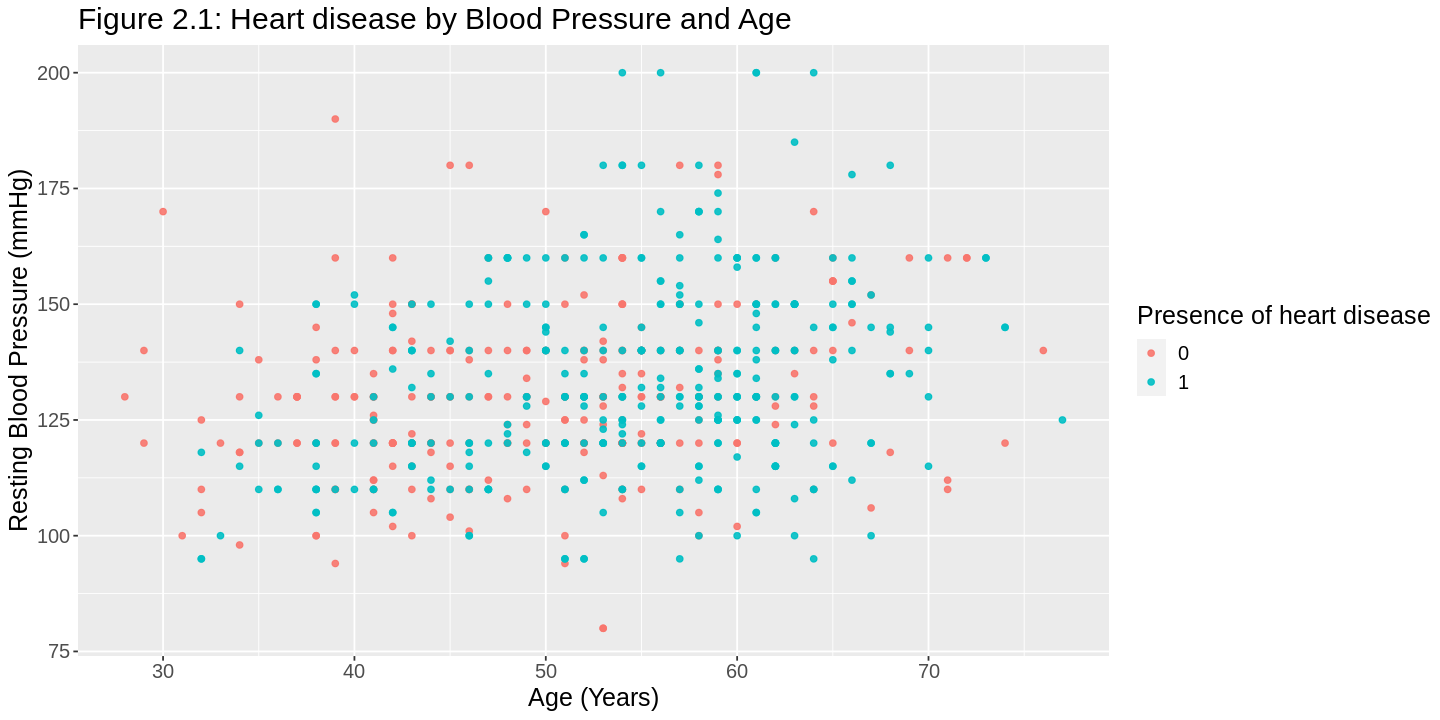

In [26]:
options(repr.plot.width = 12, repr.plot.height = 6)
heart_plot_age_bps <- heart_train |>
                ggplot(aes(x = trestbps, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 15)) +
                labs (x = 'Resting Blood Pressure (mmHg)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Figure 2.1: Heart disease by Blood Pressure and Age") +
                coord_flip()
heart_plot_age_bps

Figure 2.1 shows that there is a weak positive correlation between age and resting blood pressure, and that there is a higher presence of heart disease in older individuals with higher resting blood pressures.

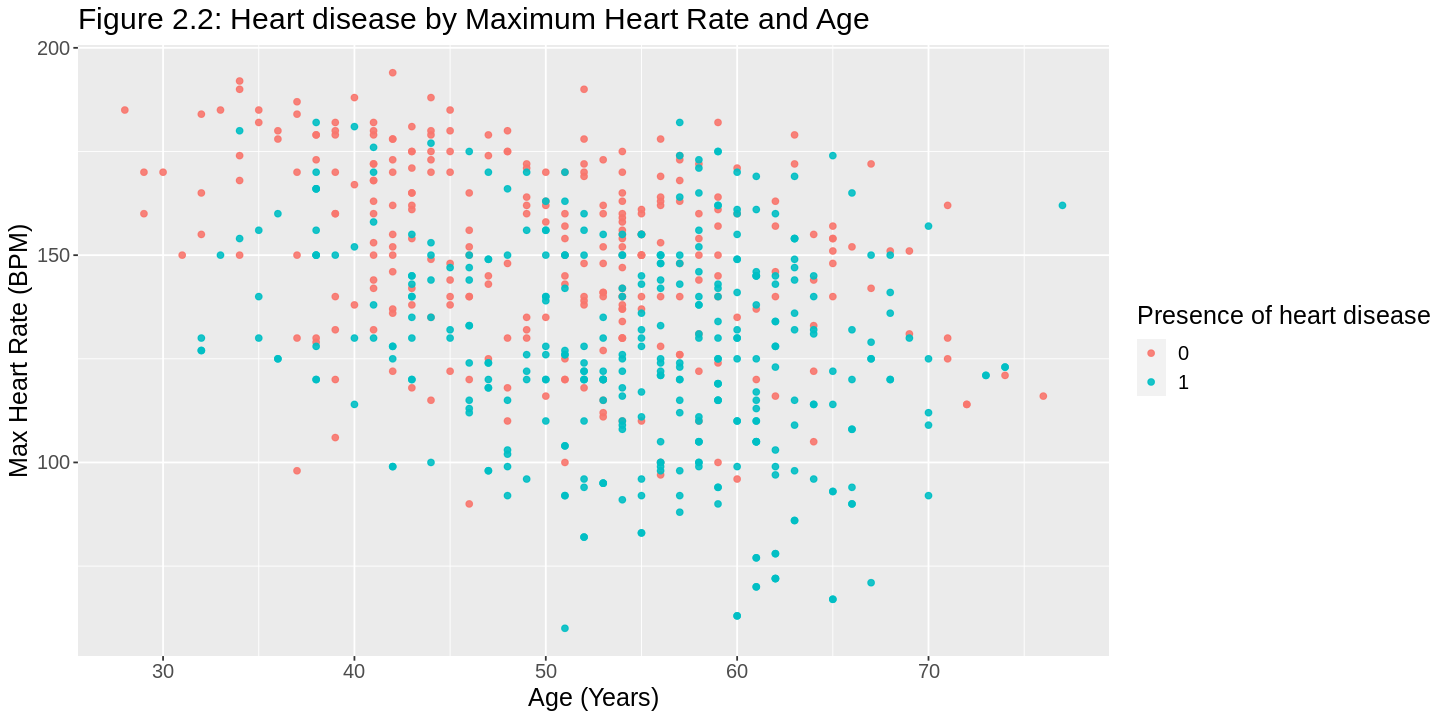

In [27]:
heart_plot_age_maxhr <- heart_train |>
                ggplot(aes(x = max_hr, y = age, color = num)) +
                geom_point(alpha = 0.9) +
                theme(text = element_text(size = 15)) +
                labs (x = 'Max Heart Rate (BPM)', y = "Age (Years)", colour = "Presence of heart disease") +
                ggtitle("Figure 2.2: Heart disease by Maximum Heart Rate and Age") +
                coord_flip()
heart_plot_age_maxhr

Figure 2.2 shows that there is a weak negative correlation between age and max heart rate, and that there is a higher presence of heart disease in older individuals with smaller max heart rates.

Each variable is weakly related to heart disease on its own. The goal of this project is to see if the *combination* of each of these variables is enough to make accurate heart disease diagnoses.

[1] 7

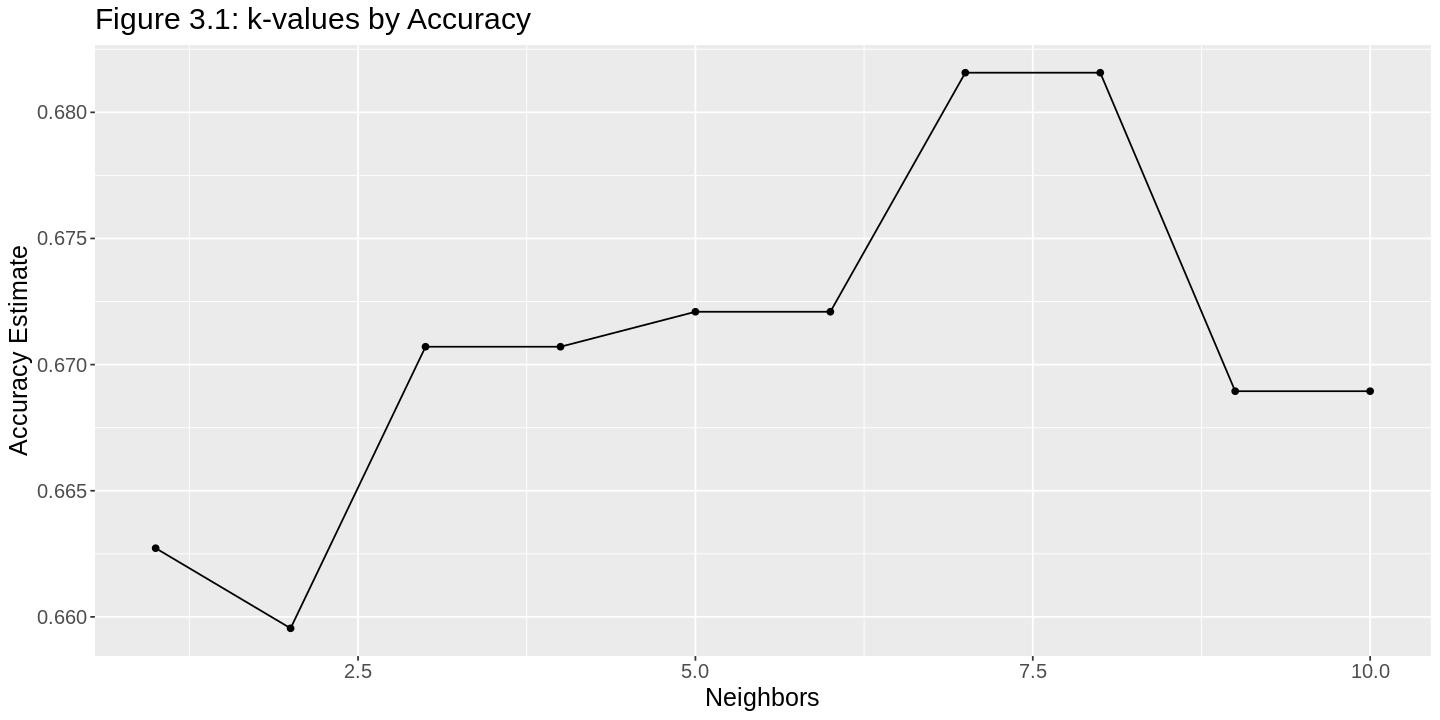

In [28]:
set.seed(1987)
# creating the recipe for everything
heart_recipe <- recipe(num ~ age + trestbps + max_hr , data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

ks <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

data_vfold <- vfold_cv(heart_train, v = 10, strata = num)

# creating the spec for the vfold
knn_spec_v <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


#creating the workflow for the vfold

accuracies <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_v) |>
  tune_grid(resamples = data_vfold, grid = ks) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

#plot of accuracy by k value
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Figure 3.1: k-values by Accuracy") +
  theme(text = element_text(size = 15))

k_min <- accuracies |>
    arrange(desc(mean)) |>
    slice(1)|>
    pull(neighbors)

accuracy_vs_k

# printing the number of ks we use
k_min

## Figure 3.1 (above)
We chose to use ***k*** nearest neighbours classification to solve this problem, using 10-fold cross-verification to reduce the impact of random chance on our model. After fitting the model to our training set, we can see the best number of ***k*** to use for our training set from the graph. We can now fit the final model using our chosen k and our training set, and determine the accuracy of it using our testing set.

In [9]:
set.seed(1987)
# creating the spec for the final model
knn_spec_f <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
  set_engine("kknn") |>
  set_mode("classification")

#creating the workflow for the final model
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec_f) |>
  fit(data = heart_train)

#determining the accuracy using our testing set
predictions <- knn_fit |>
           predict(heart_test) |>
          bind_cols(heart_test |> select(num, age, trestbps, max_hr))

#metrics
metrics <- predictions |>
           metrics(truth = num, estimate = .pred_class)
#confidence matrix
conf_mat <- predictions |>
    conf_mat(truth = num, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7190476
kap,binary,0.4231306


          Truth
Prediction  0  1
         0 58 25
         1 34 93

## Figure 3.2

In [20]:
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7190476
kap,binary,0.4231306


## Figure 3.3

In [21]:
conf_mat

          Truth
Prediction  0  1
         0 58 25
         1 34 93

We see that our model is around 72% accurate (figure 3.2), which isn’t particularly high but not particularly poor. For a closer look into our model, we can look to the confidence matrix (figure 3.3). From this, we can see the number of correct negative diagnoses, correct positive diagnoses, incorrect positive diagnoses, and incorrect negative diagnoses. Because the number of false-positives (type 1 error) and false-negatives (type 2 error) is around the same, we determine that the model is neither under-fitting nor over-fitting to the data.

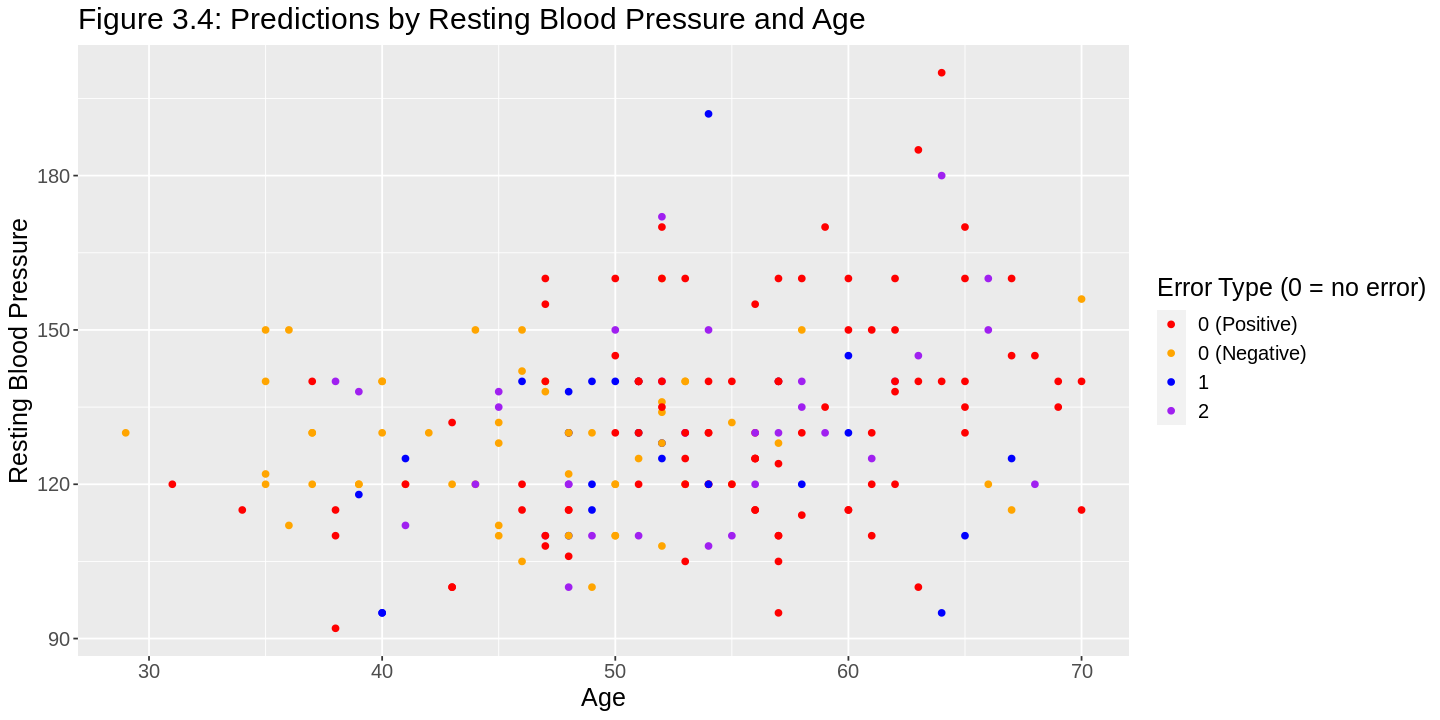

In [29]:
#plot of predictions by error type
errors <- predictions |>
    mutate(error = ifelse(num == .pred_class & num == 0, "0 (Negative)",
                          ifelse(num == .pred_class & num == 1, "0 (Positive)", ifelse(num == 1, 1, 2))))
 ggplot(errors, aes(x = age, y = trestbps, color = error)) +
  geom_point() +
    scale_color_manual(values = c("0 (Positive)" = "red", "0 (Negative)" = "orange", "1" = "blue",
                                  "2" = "purple")) +
  labs(x = "Age", y = "Resting Blood Pressure", color = "Error Type (0 = no error)",
       title = "Figure 3.4: Predictions by Resting Blood Pressure and Age") +
  theme(text = element_text(size = 15))

To visualize the confidence matrix further, we put some of our variables into a scatter plot (Figure 3.4). Due to the high dimensionality (too many variables) of the model, we cannot visualize using all of our variables, so this plot only includes resting blood pressure and age. Correct predictions are colored in warm colors and wrong predictions are colored in cool colors. From the plot, we can see that individuals that are young or have high resting blood pressures are generally being correctly classified. Most of the incorrect classifications occur in the intersection of low resting blood pressure and middle age.  

### Discussion

Based on preliminary research, we determined that there's a relationship between heart disease and all of our selected variables. So, we expected that using all four predictors would allow us to predict heart disease diagnosis with decent accuracy. Through a classification exercise we were able to confirm these suspicions and determine that using the choice variables that are inexpensive to test for (age, resting blood pressure, and maximum heart rate) results in an estimated accuracy of more than 70%.

While this figure is not great enough to replace angiograms entirely, it is significant enough to be effective as a screening test to determine at-risk individuals. Because this model has such a low cost to run, it can be included as a routine step in any checkup, potentially allowing individuals with undiagnosed heart disease to receive the attention they need.

The impact is clear: if we can routinely do cheap tests for heart disease or reduce the number of angiograms needed, it means less costly procedures for physicians and patients, leading to increased access to heart disease diagnoses. Thus directly affecting impoverished or otherwise less fortunate communities, possibly saving lives and changing the healthcare system towards greater accessibility.

Such explorations and investigations into current health care practices may cause future questions to arise. For example, we may rethink current standard diagnosis practices in medicine and explore easier, less expensive options, including but not limited to heart disease diagnosis and other cardio related disorders. Specifically, one possible question is "What other variables can we use to successfully predict heart disease with even more accuracy?"

### References

(Heart disease data set source)
Janosi, Andras., Steinbrunn, William., et al. (1988). Heart Disease [Data Set]. UC Irvine Machine Learning Repository. 10.24432/C52P4X

(Heart disease background/ diagnosis method source)
Stouffer, G., Runge, M. S., et al. (2018). Netter’s Cardiology E-Book. Elsevier Health Sciences.

(angiogram prices)
(Updated 2023). Diagnostic Scans. Canada Diagnostic. https://www.canadadiagnostic.com/info/fees/